In [ ]:
## text vecorization seems to have an error for tf_idf normalization
!pip install tensorflow -U

In [1]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import StandardScaler

from transformers import BertTokenizer

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow import keras
from tensorflow.keras import layers

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

#sklearn processing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#configs
max_tokens = 20000


gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)

os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async' 

2022-11-26 21:16:53.892091: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-26 21:16:54.866398: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-11-26 21:16:54.866542: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Co

/kaggle/input/feedback-prize-english-language-learning/sample_submission.csv
/kaggle/input/feedback-prize-english-language-learning/train.csv
/kaggle/input/feedback-prize-english-language-learning/test.csv


In [2]:
print(tf.__version__)

2.11.0


In [3]:
sample_submission_raw = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/sample_submission.csv')
train_data_raw = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/train.csv')
test_from_comp = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/test.csv')

In [4]:
train, test = train_test_split(train_data_raw, test_size=0.2, random_state=21) #20% for test
train, val = train_test_split(train, test_size=0.1, random_state=21) # 10% for validation
train

targets=['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

sc_y = StandardScaler()
train_targets = sc_y.fit_transform(train[targets])
val_targets = sc_y.transform(val[targets])
test_targets = sc_y.transform(test[targets])

train_targets_ds = tf.convert_to_tensor(train_targets)
val_targets_ds = tf.convert_to_tensor(val_targets)
test_targets_ds = tf.convert_to_tensor(test_targets)

train_text_only = tf.convert_to_tensor(train['full_text'].values)
val_text_only = tf.convert_to_tensor(val['full_text'])
test_text_only = tf.convert_to_tensor(test['full_text'])


## for submission 
all_sc_y = StandardScaler()
all_train_targets = all_sc_y.fit_transform(train_data_raw[targets])
all_train_targets_ds = tf.convert_to_tensor(all_train_targets)
all_train_text_only = tf.convert_to_tensor(train_data_raw['full_text'])
all_test_text_only = tf.convert_to_tensor(test_from_comp['full_text'])


In [5]:
text_vectorization = layers.TextVectorization(
    ngrams=2,
    max_tokens=max_tokens,
    output_mode="tf_idf",
)

#use the dataset to index the dataset vocab via the adapt method
text_vectorization.adapt(train_text_only)


train_features_ds = text_vectorization(train_text_only)
val_features_ds = text_vectorization(val_text_only)
test_features_ds = text_vectorization(test_text_only)

#for submission
all_train_features_ds = text_vectorization(all_train_text_only)
all_test_features_ds = text_vectorization(all_test_text_only)


2022-11-26 21:17:33.243920: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 312880000 exceeds 10% of free system memory.


In [8]:
def get_model(max_tokens=max_tokens, hidden_dim=32):
    
    inputs = keras.Input(shape=(max_tokens,))
    
    x = layers.LayerNormalization()(inputs)
    
    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dropout(rate=0.5)(x)
    
    x = layers.Dense(hidden_dim, activation="relu")(x)
    x = layers.Dropout(rate=0.5)(x)
    
    x = layers.Dense(hidden_dim, activation="relu")(x)
    x = layers.Dropout(rate=0.5)(x)


    outputs = layers.Dense(6, activation=None)(x)
    
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="mean_absolute_error",
        metrics=[tf.keras.metrics.RootMeanSquaredError(
                name='root_mean_squared_error', dtype=None
            )]
    )
    return model

#train model and test
model = get_model()
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("counts_2gram.keras", save_best_only=True)
]
hist = model.fit(
    x=train_features_ds,
    y=train_targets_ds,
    validation_data = (
        val_features_ds, val_targets_ds
    ),
    epochs=25,
    callbacks=callbacks
)

model = keras.models.load_model("counts_2gram.keras")
print(f"Test acc: {model.evaluate(test_features_ds, test_targets_ds, 1)}")


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_4 (Dense)             (None, 32)                640032    
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 32)                1056      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0   

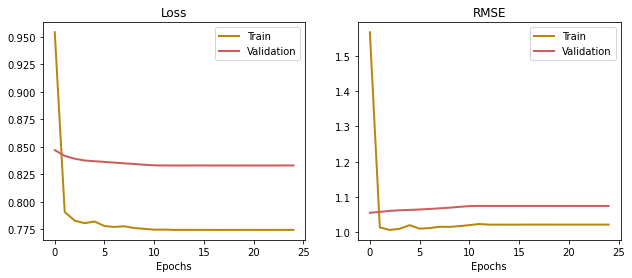

In [9]:
# grab history
history = hist.history

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)

plt.plot(history['loss'], lw=2, color='darkgoldenrod')
plt.plot(history['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
#plt.ylim(0.5,0.7)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss');

ax = fig.add_subplot(1, 3, 2)

plt.plot(history['root_mean_squared_error'], lw=2, color='darkgoldenrod')
plt.plot(history['val_root_mean_squared_error'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
#plt.ylim(0.5,0.7)
ax.set_xlabel('Epochs', size=10)
ax.set_title('RMSE');


In [10]:
#
model = get_model()
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("counts_2gram.keras", save_best_only=True)
]
hist = model.fit(
    x=all_train_features_ds,
    y=all_train_targets_ds,
    validation_data = None,
    epochs=25,
    callbacks=callbacks
)

model = keras.models.load_model("counts_2gram.keras")

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_8 (Dense)             (None, 32)                640032    
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 32)                1056      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                1056      
                                                                 
 dropout_8 (Dropout)         (None, 32)                0   

2022-11-26 21:18:55.089416: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 312880000 exceeds 10% of free system memory.


Epoch 1/25
123/123 [==============================] - 2s 4ms/step - loss: 1.0611 - root_mean_squared_error: 2.1418
Epoch 2/25
123/123 [==============================] - 1s 5ms/step - loss: 0.7857 - root_mean_squared_error: 1.0081
Epoch 3/25
123/123 [==============================] - 1s 6ms/step - loss: 0.7831 - root_mean_squared_error: 1.0208
Epoch 4/25
123/123 [==============================] - 1s 5ms/step - loss: 0.7783 - root_mean_squared_error: 1.0113
Epoch 5/25
123/123 [==============================] - 1s 4ms/step - loss: 0.7789 - root_mean_squared_error: 1.0172
Epoch 6/25
123/123 [==============================] - 1s 5ms/step - loss: 0.7766 - root_mean_squared_error: 1.0196
Epoch 7/25
123/123 [==============================] - 1s 5ms/step - loss: 0.7754 - root_mean_squared_error: 1.0209
Epoch 8/25
123/123 [==============================] - 1s 4ms/step - loss: 0.7750 - root_mean_squared_error: 1.0206
Epoch 9/25
123/123 [==============================] - 1s 4ms/step - loss: 0.7750

## Submission to contest

In [11]:
test_predictions = model.predict(all_test_features_ds)
test_predictions = pd.DataFrame(all_sc_y.inverse_transform(test_predictions))

test_from_comp['cohesion'] = test_predictions[0]
test_from_comp['syntax'] = test_predictions[1]
test_from_comp['vocabulary'] = test_predictions[2]
test_from_comp['phraseology'] = test_predictions[3]
test_from_comp['grammar'] = test_predictions[4]
test_from_comp['conventions'] = test_predictions[5]
test_from_comp

1/1 [==============================] - 0s 89ms/step


,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,when a person has no experience on a job their...,2.996298,2.99542,2.991505,3.000906,3.000606,2.99353
1,000BAD50D026,Do you think students would benefit from being...,2.996298,2.99542,2.991505,3.000906,3.000606,2.99353
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde...",2.996298,2.99542,2.991505,3.000906,3.000606,2.99353


In [ ]:
res = test_from_comp.drop("full_text",axis=1)
res.to_csv("/kaggle/working/submission.csv",index=False)